# Out-of-the-box PCA Analysis

## Example dataset
Replication data from a behavioral economic field experiment in Turkish schools. 

Alan, Sule; Boneva, Teodora; Ertac, Seda, 2019, "Replication Data for: 'Ever Failed, Try Again, Succeed Better: Results from a Randomized Educational Intervention on Grit'", https://doi.org/10.7910/DVN/SAVGAL, Harvard Dataverse, V1.


**Input:** You cleaned the data and want to inpsect its properties by applying PCA.

**Output:** Scree plot, factor loadings, Kmeans clustering, plotting PCs grouped by kmean's labels.  PCA's factor loadings highlight dimensions that cover most of the variance.

In [1]:
import pandas as pd
import numpy as np

# load data from website
import io #parse from url
import requests #load from url


#sklearn modules
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

#plots
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("talk")

In [2]:
print("RUNNING ON")
!python --version
print('Pandas ',pd.__version__)
print('Seaborn ',sns.__version__)

RUNNING ON
Python 3.7.6
Pandas  1.0.3
Seaborn  0.10.0


# Data preprocessing 
## I.  Load data and select features

### Ensure

* select features (X)
* numeric type
* no missings (removed or imputed)
* standardize

In [4]:
def features_select(data,feature_names): 
    """Select features of a dataframe
    
    Input
          data: dataframe
          features_names: list of feature names as strings
          
    Return
        dataframe: data with selected features only    
    """
    return data.filter(feature_names, axis='columns')

In [69]:
# load data from URL or revert to local copy
try:
    url = 'https://dataverse.harvard.edu/api/access/datafile/3352340?gbrecs=false'
    s=requests.get(url).content
    df_raw = pd.read_csv(io.StringIO(s.decode('utf-8')), sep='\t')
    print("Data loaded from Harvard Dataverse.")
except:
    path = 'C://Users//Philipp//GDrive//Projekter//Causal Forest Tutorial//data//grit//'
    df_raw = pd.read_csv(path+'Sample2_Data.tab', sep='\t')
    print("Data loaded from local directory.")
    
df = df_raw.copy()

# select features
selected_features = ['grit', 'male', 'task_ability', 'raven', 'grit_survey1', 
 'belief_survey1', 'mathscore1', 'verbalscore1', 'risk', 'inconsistent']
X_raw = df.filter(selected_features, axis='columns')
X_raw_colnames = X_raw.keys()

Data loaded from Harvard Dataverse.


## II. impute missings and standardize

In [5]:
# impute with mean 
imp = SimpleImputer()
X = imp.fit_transform(X_raw)

# standardize 
std_scaler = StandardScaler()
X_std = std_scaler.fit_transform(X)

# PCA
## Initialize

In [ ]:
# initialize and compute pca
pca = PCA()
X_pca = pca.fit_transform(X_std)

## Basic info

In [107]:
# get basic info
n_components = len(pca.explained_variance_ratio_)
explained_variance = pca.explained_variance_ratio_
cum_explained_variance = np.cumsum(explained_variance)
idx = np.arange(n_components)+1

df_explained_variance = pd.DataFrame([explained_variance, cum_explained_variance], 
                                     index=['explained variance', 'cumulative'], 
                                     columns=idx).T

mean_explained_variance = df_explained_variance.iloc[:,0].mean() # calculate mean explained variance

# DISPLAY info about PCs
print('PCA Overview')
print('='*40)
print("Total: {} components".format(n_components))
print('-'*40)
print('Mean explained variance:', round(mean_explained_variance,3))
print('-'*40)
print(df_explained_variance.head(20))
print('-'*40)

PCA Overview
Total: 10 components
----------------------------------------
Mean explained variance: 0.1
----------------------------------------
    explained variance  cumulative
1             0.265261    0.265261
2             0.122700    0.387962
3             0.113990    0.501951
4             0.099139    0.601090
5             0.094357    0.695447
6             0.083412    0.778859
7             0.063117    0.841976
8             0.056386    0.898362
9             0.052588    0.950950
10            0.049050    1.000000
----------------------------------------


## Scree plot

Limit scree plot to nth component (0 for all) > 3


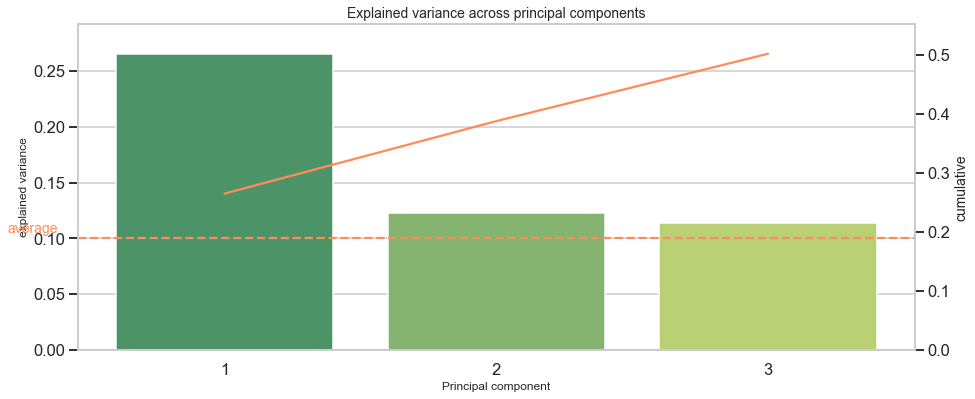

In [109]:
#limit plot to x PC
limit = int(input("Limit scree plot to nth component (0 for all) > "))
if limit > 0:
    limit_df = limit
else:
    limit_df = n_components

df_explained_variance_limited = df_explained_variance.iloc[:limit_df,:]

#make scree plot
fig, ax1 = plt.subplots(figsize=(15,6))

ax1.set_title('Explained variance across principal components', fontsize=14)
ax1.set_xlabel('Principal component', fontsize=12)
ax1.set_ylabel('Explained variance', fontsize=12)

ax2 = sns.barplot(x=idx[:limit_df], y='explained variance', data=df_explained_variance_limited, palette='summer')
ax2 = ax1.twinx()
ax2.grid(False)

ax2.set_ylabel('Cumulative', fontsize=14)
ax2 = sns.lineplot(x=idx[:limit_df]-1, y='cumulative', data=df_explained_variance_limited, color='#fc8d59')

ax1.axhline(mean_explained_variance, ls='--', color='#fc8d59') #plot mean
ax1.text(-.8, mean_explained_variance+(mean_explained_variance*.05), "average", color='#fc8d59', fontsize=14) #label y axis

max_y1 = max(df_explained_variance_limited.iloc[:,0])
max_y2 = max(df_explained_variance_limited.iloc[:,1])
ax1.set(ylim=(0, max_y1+max_y1*.1))
ax2.set(ylim=(0, max_y2+max_y2*.1))

plt.show()

## Factor loadings

In [90]:
############### DEFINE PARAMS
top_k = 3
#select data based on percentile (top_q) or top-k features
top_q = .50
top_pc = 3
###############

# PCA factor loadings
df_c = pd.DataFrame(pca.components_, columns=X_raw_colnames).T

print("Factor Loadings")
print('='*40,'\n')
print('Top {} highest'.format(top_k))
print('-'*40)
print(df_c.iloc[:,0].sort_values(ascending=False)[:top_k], '\n')

print('Top {} lowest'.format(top_k))
print('-'*40)
print(df_c.iloc[:,0].sort_values()[:top_k])

Factor Loadings

Top 3 highest
----------------------------------------
inconsistent    0.093082
male            0.084360
grit            0.048657
Name: 0, dtype: float64 

Top 3 lowest
----------------------------------------
mathscore1     -0.467809
raven          -0.452894
grit_survey1   -0.452138
Name: 0, dtype: float64


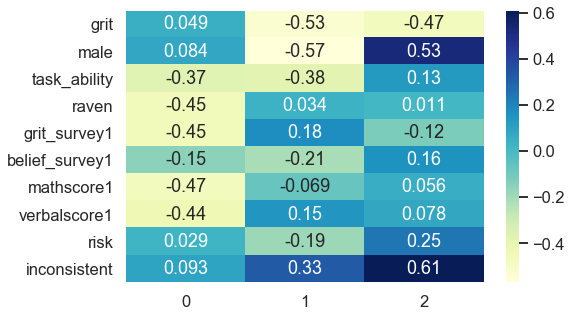

In [105]:
# Plot heatmap
size_yaxis = round(X_raw.shape[1] * 0.5)

fig, ax = plt.subplots(figsize=(8,size_yaxis))
sns.heatmap(df_c.iloc[:,:top_pc], annot=True, cmap="YlGnBu", ax=ax)
plt.show()

# Function
## do_pca()

In [140]:
import pandas as pd
from sklearn.decomposition import PCA

#plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")

def do_pca(data_std, feature_names, top_k=10, top_pc=10):
    """Conduct a PCA on standardized data. Show scree plot and heatmap factor loadings
     
    Input
        data_std: dataframe containing standardized data
        feature_names: list of features 
        top_k: Top-k variables to list for factor loadings
        top_pc: Show PC up to top_pc in scree plot and heatmap 
        
    Return 
        tuple: (pca object, pca transformation)
    """
    
    # initialize and compute pca
    pca = PCA()
    X_pca = pca.fit_transform(X_std)
    
    ## PRINT BASIC INFO
    n_components = len(pca.explained_variance_ratio_)
    explained_variance = pca.explained_variance_ratio_
    cum_explained_variance = np.cumsum(explained_variance)
    idx = np.arange(n_components)+1

    df_explained_variance = pd.DataFrame([explained_variance, cum_explained_variance], 
                                         index=['explained variance', 'cumulative'], 
                                         columns=idx).T

    mean_explained_variance = df_explained_variance.iloc[:,0].mean() # calculate mean explained variance

    print('PCA Overview')
    print('='*40)
    print("Total: {} components".format(n_components))
    print('-'*40)
    print('Mean explained variance:', round(mean_explained_variance,3))
    print('-'*40)
    print(df_explained_variance.head(20))
    print('-'*40)
    
    
    
    ## SCREE PLOT: Explained variance
    df_explained_variance_limited = df_explained_variance.iloc[:top_pc,:]

    #make scree plot
    fig, ax1 = plt.subplots(figsize=(15,6))

    ax1.set_title('Explained variance across principal components', fontsize=14)
    ax1.set_xlabel('Principal component', fontsize=12)
    ax1.set_ylabel('Explained variance', fontsize=12)

    ax2 = sns.barplot(x=idx[:top_pc], y='explained variance', data=df_explained_variance_limited, palette='YlGnBu')
    ax2 = ax1.twinx()
    ax2.grid(False)

    ax2.set_ylabel('Cumulative', fontsize=14)
    ax2 = sns.lineplot(x=idx[:top_pc]-1, y='cumulative', data=df_explained_variance_limited, color='#fc8d59')

    ax1.axhline(mean_explained_variance, ls='--', color='#fc8d59') #plot mean
    ax1.text(-.8, mean_explained_variance+(mean_explained_variance*.05), "average", color='#fc8d59', fontsize=14) #label y axis

    max_y1 = max(df_explained_variance_limited.iloc[:,0])
    max_y2 = max(df_explained_variance_limited.iloc[:,1])
    ax1.set(ylim=(0, max_y1+max_y1*.1))
    ax2.set(ylim=(0, max_y2+max_y2*.1))

    plt.show()
    
    
    
    
    ## FACTOR LOADINGS
    # df factor loadings
    df_c = pd.DataFrame(pca.components_, columns=feature_names).T

    print("Factor Loadings of 1st PC")
    print('='*40,'\n')
    print('Top {} highest'.format(top_k))
    print('-'*40)
    print(df_c.iloc[:,0].sort_values(ascending=False)[:top_k], '\n')

    print('Top {} lowest'.format(top_k))
    print('-'*40)
    print(df_c.iloc[:,0].sort_values()[:top_k])
    
    # Plot heatmap
    size_xaxis = round(top_pc * 1.5)
    size_yaxis = round(n_components * 0.5)

    fig, ax = plt.subplots(figsize=(size_xaxis,size_yaxis))
    sns.heatmap(df_c.iloc[:,:top_pc], annot=True, cmap="YlGnBu", ax=ax)
    plt.show()
    
    return pca, pd.DataFrame(X_pca)

PCA Overview
Total: 10 components
----------------------------------------
Mean explained variance: 0.1
----------------------------------------
    explained variance  cumulative
1             0.265261    0.265261
2             0.122700    0.387962
3             0.113990    0.501951
4             0.099139    0.601090
5             0.094357    0.695447
6             0.083412    0.778859
7             0.063117    0.841976
8             0.056386    0.898362
9             0.052588    0.950950
10            0.049050    1.000000
----------------------------------------


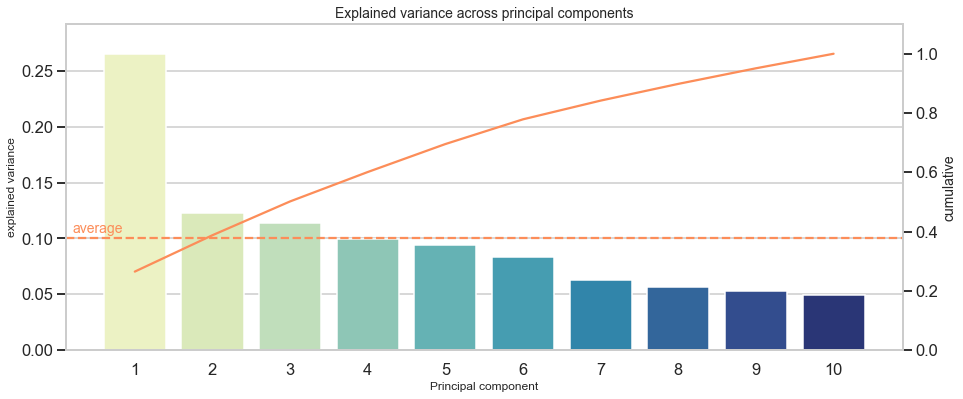

Factor Loadings of 1st PC

Top 10 highest
----------------------------------------
inconsistent      0.093082
male              0.084360
grit              0.048657
risk              0.029110
belief_survey1   -0.153302
task_ability     -0.372942
verbalscore1     -0.435924
grit_survey1     -0.452138
raven            -0.452894
mathscore1       -0.467809
Name: 0, dtype: float64 

Top 10 lowest
----------------------------------------
mathscore1       -0.467809
raven            -0.452894
grit_survey1     -0.452138
verbalscore1     -0.435924
task_ability     -0.372942
belief_survey1   -0.153302
risk              0.029110
grit              0.048657
male              0.084360
inconsistent      0.093082
Name: 0, dtype: float64


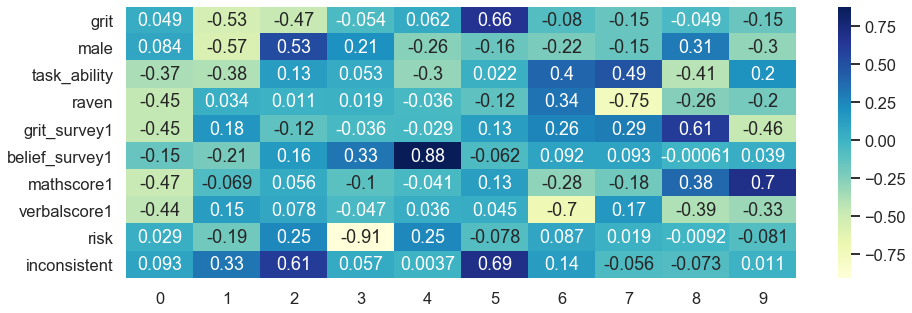

In [141]:
pca, X_pca = do_pca(X_std, X_raw_colnames)

# KMeans Clustering

In [50]:
# Sklearn
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

import itertools #for unordered pairwise combinations of list elements

# Over a number of different cluster counts...
    # run k-means clustering on the data and...

def k_mean_distance(data, centroid_x, centroid_i, cluster_labels):
    # Calculate Euclidean distance for each data point assigned to centroid
    distances = [np.linalg.norm(x-centroid_x) for x in data[cluster_labels == centroid_i]]
    # return the mean value
    return np.mean(distances)

def get_kmeans_model(data, k):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=k, random_state=42)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    clusters = model.fit_predict(data) #cluster labels
    centroids = model.cluster_centers_ #cluster centroids
    
    #SCORE METHOD: Average distance to cluster

    c_mean_distances = []    
    for i, cent_features in enumerate(centroids):
        mean_distance = k_mean_distance(data, cent_features, i, clusters)
        c_mean_distances.append(mean_distance)

    score = np.array(c_mean_distances).mean()
    
    return model, score

#TODO: nicer progress bar
scores = []
k_list = list(range(5,100,10))

for k in k_list:
    print(f">> Compute {k} clusters, progress: {int(k_list.index(k)/len(k_list)*100)}%")
    s = get_kmeans_model(X_pca, k)[1]
    scores.append(s)

# Investigate the change in within-cluster distance across number of clusters.
plt.plot(k_list, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Mean distance to cluster center');
plt.title('Mean distance to cluster center across K');

In [120]:
# Re-fit the k-means model with the selected number of clusters and obtain cluster predictions
optimal_k = int(input("Estimate the optimal k: "))
k_means_selected = KMeans(n_clusters=optimal_k, random_state=42)
k_means_selected.fit(X_pca)
preds = k_means_selected.predict(X_pca)
df_clusters = pd.concat([pd.DataFrame(X_pca), pd.Series(preds, name='cluster')], axis=1)

Estimate the optimal k: 16


In [121]:
def plot_cluster_pca(cluster_data, k, n_pc=3):
    #TODO: plot 3 in one row using subplots and ax
    #TODO: plot in nicer dims
#     dims = (11.7, 8.27)
    for i in itertools.combinations(range(n_pc),2):
        g = sns.scatterplot(data=cluster_data, hue='cluster', x=i[0], y=i[1])
    #     g._legend.remove()
        g.set(xlabel='PCA {}'.format(i[0]+1), ylabel='PCA {}'.format(i[1]+1), title=f"PCs by KMeans clusters  (k={k})")
    #     g.plt.set_size_inches(dims)
        plt.show()

plot_cluster_pca(df_clusters, optimal_k)